# Exercise 1
Calculate the convolution of the following 4x4 matrix and the 2x2 filter:

Given matrix $A$:
\begin{bmatrix}
     2 &  5 & -3 &  0 \\
     0 &  6 &  0 & -4 \\
    -1 & -3 &  0 &  2 \\
     5 &  0 &  0 &  3 \\
\end{bmatrix}

Filter $F$:
\begin{bmatrix}
    -2 & 0 \\
     4 & 6 \\
\end{bmatrix}

## By hand

1. Top-left corner (0,0):
   $(2 \times -2) + (5 \times 0) + (0 \times 4) + (6 \times 6) = -4 + 0 + 0 + 36 = 32$
2. Top-center (0,1): $(5 \times -2) + (-3 \times 0) + (6 \times 4) + (0 \times 6) = -10 + 0 + 24 + 0 = 14$
3. Top-right (0,2): $(-3 \times -2) + (0 \times 0) + (0 \times 4) + (-4 \times 6) = 6 + 0 + 0 - 24 = -18$
4. Middle-left (1,0): $(0 \times -2) + (6 \times 0) + (-1 \times 4) + (-3 \times 6) = 0 + 0 - 4 - 18 = -22$
5. Middle-center (1,1): $(6 \times -2) + (0 \times 0) + (-3 \times 4) + (0 \times 6) = -12 + 0 - 12 + 0 = -24$
6. Middle-right (1,2): $(0 \times -2) + (-4 \times 0) + (0 \times 4) + (2 \times 6) = 0 + 0 + 0 + 12 = 12$
7. Bottom-left (2,0): $(-1 \times -2) + (-3 \times 0) + (5 \times 4) + (0 \times 6) = 2 + 0 + 20 + 0 = 22$
8. Bottom-center (2,1): $(-3 \times -2) + (0 \times 0) + (0 \times 4) + (0 \times 6) = 6 + 0 + 0 + 0 = 6$
9. Bottom-right (2,2): $(0 \times -2) + (2 \times 0) + (0 \times 4) + (3 \times 6) = 0 + 0 + 0 + 18 = 18$

So, the result of the convolution is:
\begin{bmatrix}
    32 &  14 & -18 \\
   -22 & -24 &  12 \\
    22 &  24 &  18 \\
\end{bmatrix}

## By Python

In [79]:
import numpy as np

# Define input matrix
input = np.array([
    [2, 5, -3, 0],
    [0, 6, 0, -4],
    [-1, -3, 0, 2],
    [5, 0, 0, 3]
])
# Define filter matrix
filter = np.array([
    [-2, 0],
    [4, 6]
])

# Define output matrix size (since input is 4x4 and filter is 2x2, the output will be 3x3)
output = np.zeros((3, 3))

# Perform convolution operation
for i in range(output.shape[0]):
    for j in range(output.shape[1]):
        # Element-wise multiplication and sum
        region = input[i:i+2, j:j+2]
        output[i, j] = np.sum(region * filter)

print("Result of the convolution:")
print(output)

Result of the convolution:
[[ 32.  14. -18.]
 [-22. -24.  12.]
 [ 22.   6.  18.]]


# Exercise 2

In [80]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

## CUDA available?

In [81]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


## Downloading MNIST dataset

In [82]:
transform = transforms.ToTensor()
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True) # we take only 64 images at a time because of the amount of ROM available. Typically we take a power of 2.
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

## 1. Dataset Preprocessing

### a. Output dimensions of train and test datasets and size of images

In [83]:
train_data_shape = train_dataset.data.shape
test_data_shape = test_dataset.data.shape
image_size = train_dataset.data[0].shape  # Size of one image

print(f"Train dataset dimensions: {train_data_shape}")
print(f"Test dataset dimensions: {test_data_shape}")
print(f"Image size: {image_size}")

Train dataset dimensions: torch.Size([60000, 28, 28])
Test dataset dimensions: torch.Size([10000, 28, 28])
Image size: torch.Size([28, 28])


### b. Histogram of digit distribution

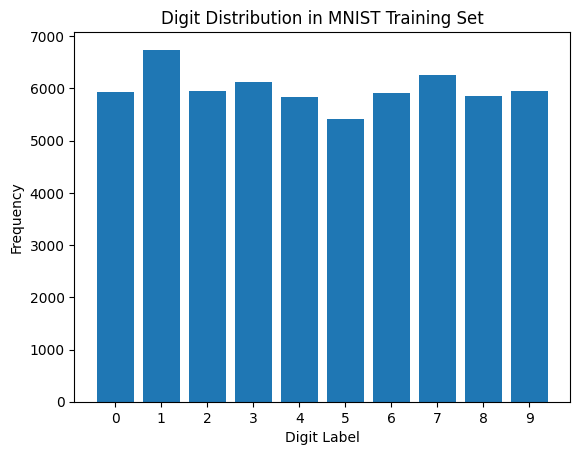

In [84]:
labels, counts = torch.unique(train_dataset.targets, return_counts=True)
plt.bar(labels.tolist(), counts.tolist())
plt.xlabel('Digit Label')
plt.ylabel('Frequency')
plt.title('Digit Distribution in MNIST Training Set')
# Set x-ticks to show each digit label (0 through 9)
plt.xticks(range(10))
plt.show()

## 2. Train a CNN

### Libraries

In [85]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.nn.functional as F

### Load the MINST dataset

In [86]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

### Define the network

In [87]:
class FlexibleNetwork(nn.Module):
    def __init__(self, layer_sizes, dropout_rate=0.0):
        super(FlexibleNetwork, self).__init__()
        layers = []
        in_channels = 1
        for out_channels in layer_sizes['conv_layers']:
            layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1))
            layers.append(nn.ReLU())
            layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
            in_channels = out_channels
        self.conv_layers = nn.Sequential(*layers)
        self.fc1 = nn.Linear(in_channels * 7 * 7, layer_sizes['fc_layer'])
        self.fc2 = nn.Linear(layer_sizes['fc_layer'], 10)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(-1, self.fc1.in_features)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

### Train the model function

In [88]:
def train_model(label='Training', layer_sizes=None, dropout_rate=0.5, optimizer_type='Adam', momentum=None, n_epochs=5):
    model = FlexibleNetwork(layer_sizes, dropout_rate=dropout_rate)
    criterion = nn.CrossEntropyLoss()

    # Select optimizer
    if optimizer_type == 'SGD':
        if momentum is not None and momentum > 0:
            optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=momentum)
        else:
            optimizer = optim.SGD(model.parameters(), lr=0.01)  # SGD without momentum
    elif optimizer_type == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=0.01)
    else:
        raise ValueError("Unsupported optimizer type")

    train_loss = 0.0
    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []

    print(f"\nExperiment: {label}")
    for epoch in range(n_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            train_loss += loss.item()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        train_losses.append(running_loss / len(train_loader))
        train_accuracy = 100 * correct / total
        train_accuracies.append(train_accuracy)

        # Evaluation on test set
        model.eval()
        test_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                outputs = model(images)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        test_losses.append(test_loss / len(test_loader))
        test_accuracy = 100 * correct / total
        test_accuracies.append(test_accuracy)

        print(f"Epoch {epoch+1}/{n_epochs} | Train Loss: {train_losses[-1]:.4f} (acc. {train_accuracy:.2f}%) | Test Loss: {test_losses[-1]:.4f} (acc. {test_accuracy:.2f}%)")
    
    return train_losses, test_losses, test_accuracies

### Default config

In [89]:
default_config = {
    "layer_sizes": {"conv_layers": [32, 64], "fc_layer": 128},
    "dropout_rate": 0.0,
    "optimizer_type": "Adam",
    "momentum": None,
    "n_epochs": 5,
    "label": "Default Experiment"
}

### Result handler

In [90]:

# Define result handler
def result_handler(experiment_configs):
    results = {}
    for config in experiment_configs:
        label = config["label"]
        train_losses, test_losses, test_accuracies = train_model(
            label=label,
            layer_sizes=config["layer_sizes"],
            dropout_rate=config["dropout_rate"],
            optimizer_type=config["optimizer_type"],
            momentum=config["momentum"],
            n_epochs=config["n_epochs"]
        )
        results[label] = {
            "train_losses": train_losses,
            "test_losses": test_losses,
            "test_accuracies": test_accuracies
        }
    return results

### Plot handler

In [91]:
def plot_handler(results, experiment_configs):
    num_experiments = len(experiment_configs)
    fig, axs = plt.subplots(1, num_experiments, figsize=(5 * num_experiments, 5), sharey=False)
    epochs = range(1, default_config["n_epochs"] + 1)
    
    for i, (label, data) in enumerate(results.items()):
        axs[i].plot(epochs, data["train_losses"], marker='o', label="Train Loss")
        axs[i].plot(epochs, data["test_losses"], marker='o', linestyle='--', label="Test Loss")
        axs[i].plot(epochs, data["test_accuracies"], marker='x', linestyle=':', label="Test Accuracy (%)")
        axs[i].set_title(label)
        axs[i].set_xlabel('Epoch')
        axs[i].set_ylabel('Metric')
        axs[i].legend()
    
    plt.tight_layout()
    plt.show()

### Configs

In [92]:
configs = [
    {**default_config, "dropout_rate": 0.2, "label": "Drop(0.2)"},
    {**default_config, "dropout_rate": 0.4, "label": "Drop(0.4)"},
    {**default_config, "dropout_rate": 0.6, "label": "Drop(0.6)"},
]

### Run experiments

In [93]:
drop_results = result_handler(configs)
plot_handler(drop_results, configs)


Experiment: Drop(0.2)


KeyboardInterrupt: 